In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.eqtl_classification import *

In [2]:
root_dir = "/clusterfs/nilah/pooja"
fig_dir = f"{root_dir}/CellTypeSpecificAccessibilityPrediction/figures"

### GWAS

In [3]:
trait_metadata = {"Asthma": ["6152_8", "Blood/Immune", "immune_atlas"],
                  "Eczema": ["6152_9", "Blood/Immune", "immune_atlas"],
                  "Creatinine": ["30700_irnt", "Kidney", "kidney_data"]}
run = "baseline_remove_enhancer_promoter_annots"
models = ["Enformer", "Enformer (same number of tracks)", "multitask", "multitask_8x_params_same_layers", "single_task"]
annot_labels = ["Less cell type specific mean SAD bin bottom 0.5",
                "Less cell type specific mean SAD bin top 0.5",
                "More cell type specific mean SAD bin bottom 0.5",
                "More cell type specific mean SAD bin top 0.5"]


ldsc_results = {}
for model in models:
    ldsc_results[model] = {}
    for trait, (trait_code, trait_tissue, dataset) in trait_metadata.items():
        trait_tissue_formatted = trait_tissue.replace('/', '_')
        
        if model in ["multitask", "multitask_8x_params_same_layers", "single_task"]:
            results_dir = f"/clusterfs/nilah/pooja/{dataset}/ldsc/partitioned_heritability"
            annots = [f"less_cell_type_specific_{dataset}_{model}_mean_sad_bin_bottom_0.5", 
                      f"less_cell_type_specific_{dataset}_{model}_mean_sad_bin_top_0.5",
                     f"more_cell_type_specific_{dataset}_{model}_mean_sad_bin_bottom_0.5", 
                      f"more_cell_type_specific_{dataset}_{model}_mean_sad_bin_top_0.5"]
        elif model == "Enformer":
            results_dir = "/global/scratch/users/poojakathail/enformer/ldsc/out"
            annots = [f"less_cell_type_specific_mean_sad_bin_bottom_0.5", 
                      f"less_cell_type_specific_mean_sad_bin_top_0.5",
                     f"more_cell_type_specific_mean_sad_bin_bottom_0.5", 
                      f"more_cell_type_specific_mean_sad_bin_top_0.5"]
        elif model == "Enformer (same number of tracks)":
            results_dir = "/global/scratch/users/poojakathail/enformer/ldsc/out"
            annots = [f"less_cell_type_specific_mean_sad_bin_bottom_0.5_match_tissue_specific_tracks", 
                      f"less_cell_type_specific_mean_sad_bin_top_0.5_match_tissue_specific_tracks",
                     f"more_cell_type_specific_mean_sad_bin_bottom_0.5_match_tissue_specific_tracks", 
                      f"more_cell_type_specific_mean_sad_bin_top_0.5_match_tissue_specific_tracks"]

        trait_results = []
        for i, annot in enumerate(annots):
            tmp_df = pd.read_csv(
            f"{results_dir}/{trait_code}_{run}_{trait_tissue_formatted}_{annot}.results", 
            sep="\t", header=0, index_col=0)[-1:]
            tmp_df.index = [annot_labels[i]]
            trait_results.append(tmp_df)

        ldsc_results[model][trait]  = pd.concat(trait_results)
 
ldsc_results["All"] = {}
for trait, (trait_code, trait_tissue, dataset) in trait_metadata.items():
    trait_tissue_formatted = trait_tissue.replace('/', '_')
    results_dir = "/global/scratch/users/poojakathail/enformer/ldsc/out"
    annots = [f"less_cell_type_specific", 
              f"more_cell_type_specific"]
    trait_results = []
    for i, annot in enumerate(annots):
        tmp_df = pd.read_csv(
        f"{results_dir}/{trait_code}_{run}_{trait_tissue_formatted}_{annot}.results", 
        sep="\t", header=0, index_col=0)[-1:]
        tmp_df.index = [annot]
        trait_results.append(tmp_df)

        ldsc_results["All"][trait]  = pd.concat(trait_results)

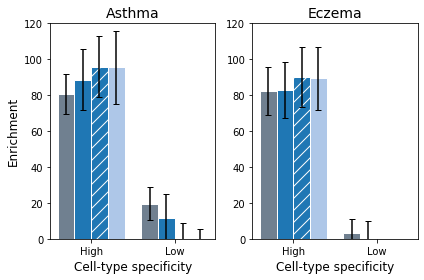

In [66]:
width = 0.2
cmap = plt.get_cmap("tab20")
colors = [cmap(0), cmap(0), cmap(1)]
plot_col = "Enrichment"
annot_cols = ["More cell type specific mean SAD bin top 0.5", "Less cell type specific mean SAD bin top 0.5"]

fig, ax = plt.subplots(1, 2, figsize=(3*2, 4*1))
for j, trait in enumerate(["Asthma", "Eczema"]):
    ax[j].bar(np.arange(len(annot_cols)),
                  ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], plot_col], width,
                  yerr=ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], f"{plot_col}_std_error"],
                  capsize=3, label=model_label, color="slategray",edgecolor="white")
              
    for i, model in enumerate(["multitask", "multitask_8x_params_same_layers", "single_task"]):
        if model == "single_task":
            model_label = "Single-task predictions"
        elif model == "multitask":
            model_label = "Multi-task predictions"
        elif model == "multitask_8x_params_same_layers":
            model_label =  "Multi-task (8x params) predictions"
        ax[j].bar(np.arange(len(annot_cols))+width*(i+1),
                  ldsc_results[model][trait].loc[annot_cols, plot_col], width,
                  yerr=ldsc_results[model][trait].loc[annot_cols, f"{plot_col}_std_error"],
                  capsize=3, label=model_label, color=colors[i], hatch='//' if model=="multitask_8x_params_same_layers" else None, 
                  edgecolor="white")

        
    ax[j].set_ylim(bottom=0, top=120)
    ax[j].set_title(trait.split("(")[0], fontsize=14)
    ax[j].set_xticks(np.arange(2)+width*1.5)
    ax[j].set_xticklabels(["High", "Low"]) 
    ax[j].set_xlabel("Cell-type specificity", fontsize=12)
    if j == 0:
        ax[j].set_ylabel("Enrichment", fontsize=12)
    if j == len(trait_metadata) - 1:
        ax[j].legend(loc=(1.01, 0))

plt.tight_layout()
plt.savefig(f"{fig_dir}/fig4/gwas_enrichment_immune_multi_vs_single_task.pdf",
            dpi=300)

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/kernel/__main__.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


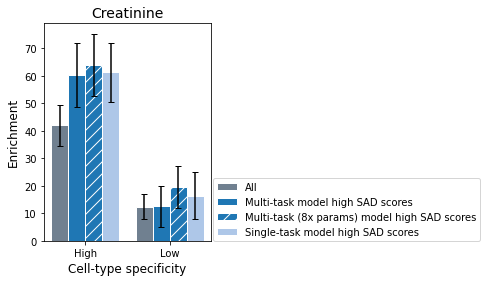

In [65]:
width = 0.2
cmap = plt.get_cmap("tab20")
colors = [cmap(0), cmap(0), cmap(1)]
plot_col = "Enrichment"
annot_cols = ["More cell type specific mean SAD bin top 0.5", "Less cell type specific mean SAD bin top 0.5"]

fig, ax = plt.subplots(1, 1, figsize=(3*1, 4*1))
for j, trait in enumerate(["Creatinine"]):
    ax.bar(np.arange(len(annot_cols)),
                  ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], plot_col], width,
                  yerr=ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], f"{plot_col}_std_error"],
                  capsize=3, label="All", color="slategray",edgecolor="white")
    
    for i, model in enumerate(["multitask", "multitask_8x_params_same_layers", "single_task"]):
        if model == "single_task":
            model_label = "Single-task model high SAD scores"
        elif model == "multitask":
            model_label = "Multi-task model high SAD scores"
        elif model == "multitask_8x_params_same_layers":
            model_label =  "Multi-task (8x params) model high SAD scores"
        ax.bar(np.arange(len(annot_cols))+width*(i+1),
                  ldsc_results[model][trait].loc[annot_cols, plot_col], width,
                  yerr=ldsc_results[model][trait].loc[annot_cols, f"{plot_col}_std_error"],
                  capsize=3, label=model_label, color=colors[i], hatch='//' if model=="multitask_8x_params_same_layers" else None, 
                  edgecolor="white")

        
    ax.set_ylim(bottom=0, top=None)
    ax.set_title(trait.split("(")[0], fontsize=14)
    ax.set_xticks(np.arange(2)+width*1.5)
    ax.set_xticklabels(["High", "Low"]) 
    ax.set_xlabel("Cell-type specificity", fontsize=12)
    ax.set_ylabel("Enrichment", fontsize=12)
    ax.legend(loc=(1.01, 0))

plt.tight_layout()
plt.savefig(f"{fig_dir}/fig4/gwas_enrichment_kidney_multi_vs_single_task.pdf",
            dpi=300, bbox_inches="tight")

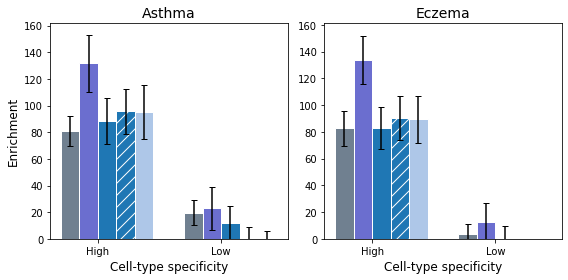

In [8]:
width = 0.15
cmap = plt.get_cmap("tab20")
cmap2  = plt.get_cmap("tab20b")
colors = [cmap2(2), cmap(0), cmap(0), cmap(1)]
plot_col = "Enrichment"
annot_cols = ["More cell type specific mean SAD bin top 0.5", "Less cell type specific mean SAD bin top 0.5"]

fig, ax = plt.subplots(1, 2, figsize=(4*2, 4*1))
for j, trait in enumerate(["Asthma", "Eczema"]):
    ax[j].bar(np.arange(len(annot_cols)),
                  ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], plot_col], width,
                  yerr=ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], f"{plot_col}_std_error"],
                  capsize=3, label="All", color="slategray",edgecolor="white")
              
    for i, model in enumerate(["Enformer",  "multitask", "multitask_8x_params_same_layers", "single_task"]):
        if model == "single_task":
            model_label = "Single-task predictions"
        elif model == "multitask":
            model_label = "Multi-task predictions"
        elif model == "multitask_8x_params_same_layers":
            model_label =  "Multi-task (8x params) predictions"
        else:
            model_label = "Enformer"
        ax[j].bar(np.arange(len(annot_cols))+width*(i+1),
                  ldsc_results[model][trait].loc[annot_cols, plot_col], width,
                  yerr=ldsc_results[model][trait].loc[annot_cols, f"{plot_col}_std_error"],
                  capsize=3, label=model_label, color=colors[i], hatch='//' if model=="multitask_8x_params_same_layers" else None, 
                  edgecolor="white")

        
    ax[j].set_ylim(bottom=0, top=None)
    ax[j].set_title(trait.split("(")[0], fontsize=14)
    ax[j].set_xticks(np.arange(2)+width*1.5)
    ax[j].set_xticklabels(["High", "Low"]) 
    ax[j].set_xlabel("Cell-type specificity", fontsize=12)
    if j == 0:
        ax[j].set_ylabel("Enrichment", fontsize=12)
    if j == len(trait_metadata) - 1:
        ax[j].legend(loc=(1.01, 0))

plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/gwas_enrichment_immune_enformer_basset_no_matched_track.pdf",
            dpi=300)

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/kernel/__main__.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


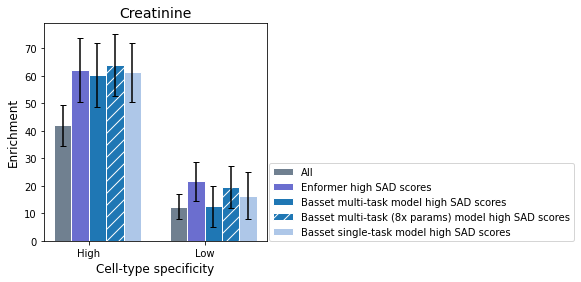

In [9]:
width = 0.15
cmap = plt.get_cmap("tab20")
cmap2  = plt.get_cmap("tab20b")
colors = [cmap2(2),  cmap(0), cmap(0), cmap(1)]
plot_col = "Enrichment"
annot_cols = ["More cell type specific mean SAD bin top 0.5", "Less cell type specific mean SAD bin top 0.5"]

fig, ax = plt.subplots(1, 1, figsize=(4*1, 4*1))
for j, trait in enumerate(["Creatinine"]):
    ax.bar(np.arange(len(annot_cols)),
                  ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], plot_col], width,
                  yerr=ldsc_results["All"][trait].loc[["more_cell_type_specific", "less_cell_type_specific"], f"{plot_col}_std_error"],
                  capsize=3, label="All", color="slategray",edgecolor="white")
    
    for i, model in enumerate(["Enformer",  "multitask", "multitask_8x_params_same_layers", "single_task"]):
        if model == "single_task":
            model_label = "Basset single-task model high SAD scores"
        elif model == "multitask":
            model_label = "Basset multi-task model high SAD scores"
        elif model == "multitask_8x_params_same_layers":
            model_label =  "Basset multi-task (8x params) model high SAD scores"
        elif model == "Enformer":
            model_label = "Enformer high SAD scores"
        else:
            model_label = "Enformer high SAD scores (matched number of tracks)"
        ax.bar(np.arange(len(annot_cols))+width*(i+1),
                  ldsc_results[model][trait].loc[annot_cols, plot_col], width,
                  yerr=ldsc_results[model][trait].loc[annot_cols, f"{plot_col}_std_error"],
                  capsize=3, label=model_label, color=colors[i], hatch='//' if model=="multitask_8x_params_same_layers" else None, 
                  edgecolor="white")

        
    ax.set_ylim(bottom=0, top=None)
    ax.set_title(trait.split("(")[0], fontsize=14)
    ax.set_xticks(np.arange(2)+width*1.5)
    ax.set_xticklabels(["High", "Low"]) 
    ax.set_xlabel("Cell-type specificity", fontsize=12)
    ax.set_ylabel("Enrichment", fontsize=12)
    ax.legend(loc=(1.01, 0))

plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/gwas_enrichment_kidney_enformer_basset_no_matched_track.pdf",
            dpi=300, bbox_inches="tight")